In [4]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle as pk
import json
import hashlib
import collections
from tqdm.notebook import tqdm
from pyvis.network import Network

In [5]:
class Cluster:
    def __init__(self,proteins):
        self.proteins = proteins

    def __len__(self):
        return len(self.proteins)

    def __repr__(self):
        reprStr = "Cluster of {} [{},{},...] (hash {})".format(len(self), self.proteins[0], self.proteins[1], hash(self))
        if hasattr(self, 'G'):
            reprStr += "\nTriangles: {}\nMax Degree: {}".format(self.triangles(), max(self.G.degree(), key=lambda x: x[1])[1])
        if hasattr(self, 'GO_terms'):
            reprStr += "\nTop Terms:\n\t{}".format('\n\t'.join(
                    ['{} ({})'.format(i[0], i[1]) for i in self.get_top_terms(5)]
            ))
        return reprStr

    def __hash__(self):
        return int(hashlib.md5(''.join(self.proteins).encode()).hexdigest(), 16)

    def to_dict(self):
        D = {}
        D['id'] = hash(self)
        D['proteins'] = []
        for p in self.proteins:
            pD = {}
            pD['name'] = p
            if hasattr(self, 'GO_DB'):
                pD['go'] = self.GO_DB[self.GO_DB['seq'] == p]['GO_ids'].values[0]
            D['proteins'].append(pD)
        if hasattr(self, 'GO_DB'):
            D['go'] = sorted([{"id": i.ID, "desc": i.name, "freq": self.GO_terms[i]} for i in self.GO_terms], key = lambda x: x['freq'], reverse=True)
        if hasattr(self,'G'):
            D['graph'] = list(self.G.edges())
        return D

    def to_json(self):
        return json.dumps(self.to_dict())

    def add_GO_terms(self, go_db, GO_OBJECTS):
        self.GO_terms = {}
        self.GO_DB = go_db
        for prot in self.proteins:
            goIds = go_db[go_db['seq'] == prot]['GO_ids'].values[0]
            if goIds is None or len(goIds) == 0:
                continue
            for gid in goIds:
                if gid in GO_OBJECTS:
                    goObj = GO_OBJECTS[gid]
                # except KeyError:
                #     GO_OBJECTS[gid] = GO(gid,{'id':gid,'name':gid})
                #     goObj = GO_OBJECTS[gid]
                    goCount = self.GO_terms.setdefault(goObj,0)
                    self.GO_terms[goObj] = goCount + 1

    def get_proteins_by_GO(self, GO_id):
        return [p for p in self.proteins if GO_id in prot_go_db.loc[p,'GO_ids']]

    def get_GO_by_protein(self, protein):
        assert protein in self.proteins, "{} not in cluster".format(protein)
        return [gt for gt in coi.GO_terms if gt.ID in prot_go_db.loc[protein,'GO_ids']]

    def get_top_terms(self,N):
        if not hasattr(self, 'GO_terms'):
            raise NotImplementedError("GO Terms have not been added yet.")
        GOlist = list(self.GO_terms.keys())
        if N == -1:
            N = len(GOlist)
        sortedList = sorted(GOlist,key=lambda x: self.GO_terms[x],reverse=True)[:N]
        return list(zip(sortedList, [self.GO_terms[i] for i in sortedList]))

    def set_graph(self,G):
        self.G = G.subgraph(self.proteins)

    def triangles(self):
        return sum([i for i in nx.triangles(self.G).values()]) / 3

    def draw_degree_histogram(self,draw_graph=True):
        if not hasattr(self,'G'):
            raise ValueError('Run .set_graph() method on this cluster first')
        G = self.G
        degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
        degreeCount = collections.Counter(degree_sequence)
        deg, cnt = zip(*degreeCount.items())
        fig, ax = plt.subplots()
        plt.bar(deg, cnt, width=0.80, color='b')

        plt.title("Degree Histogram")
        plt.ylabel("Count")
        plt.xlabel("Degree")
        ax.set_xticks([d + 0.4 for d in deg])
        ax.set_xticklabels(deg)

        # draw graph in inset
        if draw_graph:
            plt.axes([0.4, 0.4, 0.5, 0.5])
            pos = nx.spring_layout(G, k=0.15,iterations=10)
            plt.axis('off')
            nx.draw_networkx_nodes(G, pos, node_size=20)
            nx.draw_networkx_edges(G, pos, alpha=0.4)
        plt.show()

    # def draw_graph(self):
    #     if not hasattr(self,'G'):
    #         raise ValueError('Run .set_graph() method on this cluster first')
    #     G = self.G
    #     nx.draw_kamada_kawai(G, with_labels=True,node_size=600, font_size=8)
    
    def draw_graph(self, xsize=800, ysize=800, notebook=True, cdn_resources='remote'):
        if not hasattr(self,'G'):
            raise ValueError('Run .set_graph() method on this cluster first')
        nt = Network(f'{xsize}px', f'{ysize}px',notebook=notebook, cdn_resources=cdn_resources)
        nt.from_nx(self.G)
        return nt.show(f'{hash(self)}.html')
    
def read_cluster_objects(infile,sep=','):
    clusts = []
    with open(infile,'r') as f:
        for line in f:
            clusts.append(Cluster(line.strip().split(sep)))
    return clusts

def cluster_from_json(jsonString, GO_OBJECTS):
        clust = Cluster([])
        D = json.loads(jsonString)
        clust.proteins = [i['name'] for i in D['proteins']]
        clust.GO_terms = {}
        for goDict in D['go']:
            gid = goDict['id']
            gdesc = goDict['desc']
            try:
                goObj = GO_OBJECTS[gid]
            except KeyError:
                GO_OBJECTS[gid] = GO(gid,{'id':gid,'name':gdesc})
                goObj = GO_OBJECTS[gid]
            clust.GO_terms[goObj] = goDict['freq']
        try:
            edgeList = D['graph']
            G = nx.Graph()
            for e in edgeList:
                G.add_edge(*e)
            clust.G = G
        except KeyError:
            pass
        return clust

In [6]:
class GO:
    def __init__(self, ID, features):
        self.ID = ID
        self.D = features
        self.name = features['name']

    def __repr__(self):
        return '{} - <{}>'.format(self.ID, self.name)

    def __eq__(self, other):
        return self.ID == other.ID

    def __hash__(self):
        return hash(self.ID)

def extract_GO_id_from_list(l):
    if isinstance(l,list):
        return [i.split('|')[0] for i in l]
    else:
        return None

def read_GO_obo(infile):
    terms = {}
    with open(infile,'r') as f:
        for line in f:
            tDict = {}
            line = line.strip()
            if line == "[Term]":
                line = f.readline().strip().split(': ')
                while not line == ['']:
                    tDict[line[0]] = ''.join(line[1:])
                    line = f.readline().strip().split(': ')
                for k,v in tDict.items():
                    k = k.strip()
                    v = v.strip()
                    tDict[k] = v
                terms[tDict['id']] = GO(tDict['id'], tDict)
    return terms

def GO_search(clusters, GO_term, GO_OBJECTS, N=20):
    if isinstance(GO_term,str):
        GO_term = GO_OBJECTS[GO_term]
    return [c for c in clusters if GO_term in [i[0] for i in c.get_top_terms(N)]]

def protein_search(clusters, protein_list):
    if isinstance(protein_list, str):
        protein_list = [protein_list]
    plist = [c for c in clusters if np.array([p in c.proteins for p in protein_list]).all()]
    if len(plist) == 0:
        return None
    elif len(plist) == 1:
        return plist[0]
    else:
        return plist
    
def triangle_search(clusters, min_triangles=0, max_triangles=np.infty):
    return [c for c in clusters if c.triangles() >= min_triangles and c.triangles() <= max_triangles]

def node_search(clusters, min_nodes=0, max_nodes=np.infty):
    return [c for c in clusters if len(c) >= min_nodes and len(c) <= max_nodes]

## Parameters to Modify

In [8]:
net_name = 'Pdam' # TODO: options: 'Pdam', 'SymbC1'
BASE_DIR = '..'
DATA_DIR = f'{BASE_DIR}/data/'
OUTPUT_DIR = f'{BASE_DIR}/results/recipe/'

edge_weight_thresh = 0.5
n_connecting_edges = 10
go_db_file =f"{DATA_DIR}/go.obo"
goslim_db_file = f"{DATA_DIR}/goslim_generic.obo"
interactionFile = f'{DATA_DIR}/{net_name}_predictions_positive.tsv'
# clusters_file = f"{OUTPUT_DIR}{net_name}.clusters.csv"
clusters_file = f"{OUTPUT_DIR}{net_name}.recipe_clusters.csv"

cluster_size_dist_file = f"{OUTPUT_DIR}{net_name}.clust_size_dist.png"

---

## Load Clusters

In [9]:
clusters = read_cluster_objects(clusters_file)

In [10]:
protein_names = set()
for c in clusters:
    protein_names = protein_names.union(c.proteins)

In [11]:
G_init = nx.read_weighted_edgelist(interactionFile)
print('Selecting subgraph...')
G_sub = G_init.subgraph(protein_names)
print('Filtering edges with confidence threshold {}...'.format(edge_weight_thresh))
G = nx.Graph()
for (u,v,d) in tqdm(G_sub.edges.data()):
    if d['weight'] >= edge_weight_thresh:
        G.add_edge(u,v,weight=d['weight'])
degrees = [i[1] for i in list(G.degree())]

Selecting subgraph...
Filtering edges with confidence threshold 0.5...


  0%|          | 0/228796 [00:00<?, ?it/s]

In [12]:
for i in clusters:
    i.set_graph(G)

In [39]:
for c in clusters:
    if hash(c) == 363960421304215792:
        break

In [43]:
nx.write_edgelist(c.G,'test.csv')

Number of clusters: 582
Average cluster size: 25.84020618556701


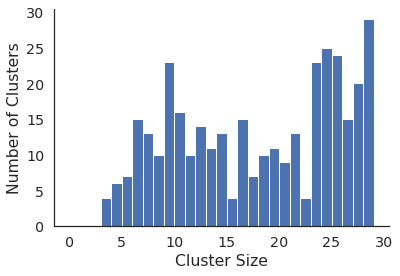

In [13]:
sns.set(style="white",font_scale=1.3)
print(f"Number of clusters: {len(clusters)}")
print(f"Average cluster size: {np.mean([len(i) for i in clusters])}")
plt.hist([len(i) for i in clusters],bins=np.arange(0,30,1))
plt.xlabel("Cluster Size")
plt.ylabel("Number of Clusters")
sns.despine()
plt.savefig(cluster_size_dist_file,dpi=300,bbox_inches='tight',transparent=True)
plt.show()

---

## Add Function to Clusters

In [14]:
def clean_GO_map(f):
    seqDb = pd.read_csv(f,sep=',')
    seqDb.columns = ['seq','manual_annot','pfam_list','GO_list']
    seqDb['GO_str'] = seqDb['GO_list']
    seqDb['GO_list'] = seqDb['GO_str'].str.split(';')
    def extract_GO_id_from_list(l):
        if isinstance(l,list):
            return [i.split('|')[0] for i in l]
        else:
            return None
    seqDb['GO_ids'] = seqDb['GO_list'].apply(extract_GO_id_from_list)
    seq2GO = seqDb[['seq','GO_ids']]
    seq2GO.columns = ['seq','GO_ids']
    return seq2GO

In [15]:
pdamMap = clean_GO_map('~/Work/Coral_Experimental_Validation/Pdam_CV3_E7_Predictions/Pdam_GO_map.csv')

In [16]:
GO_OBJECTS = read_GO_obo(go_db_file)
GO_SLIM = read_GO_obo(goslim_db_file)
print('Adding GO Annotations...')
for clust in tqdm(clusters):
    clust.add_GO_terms(pdamMap,GO_SLIM)
clusters.sort(key=lambda x: len(x), reverse=True)

Adding GO Annotations...


  0%|          | 0/582 [00:00<?, ?it/s]

In [19]:
def clean_top_terms(c, return_counts=True, n_filter=3):
    csize = len(c)
    tt = c.get_top_terms(1)
    if len(tt):
        if tt[0][1] < n_filter:
            pass
        elif return_counts:
            return (tt[0][0].name, tt[0][1], csize)
        else:
            return tt[0][0].name
    if return_counts:
        return ('', None, csize)
    else:
        return ''

In [20]:
cluster_top_terms = {hash(c): clean_top_terms(c, return_counts=False) for c in clusters}

In [21]:
from collections import Counter
counter = Counter(cluster_top_terms.values())
counter

Counter({'inflammatory response': 92,
         'DNA binding': 26,
         'GTPase activity': 65,
         '': 214,
         'cell adhesion': 26,
         'lipid binding': 27,
         'DNA repair': 46,
         'RNA binding': 13,
         'protein tag activity': 14,
         'ligase activity': 9,
         'respiratory system process': 6,
         'cytoskeletal motor activity': 10,
         'protein folding chaperone': 6,
         'molecular adaptor activity': 9,
         'wound healing': 1,
         'virus receptor activity': 15,
         'transferase activity': 1,
         'histone binding': 2})

---

## Create Cluster Graph

In [22]:
def test_cluster_connection(c1_graph, c2_graph, parent_graph):
    return len(list(nx.edge_boundary(parent_graph, c1_graph.nodes, c2_graph.nodes)))

In [ ]:
clusG = nx.Graph()

for c in clusters:
    clusG.add_node(c, size=len(c))

for n in tqdm(clusG.nodes):
    for n2 in clusG.nodes:
        # thresh = (len(n) + len(n2) // 4)
        if n != n2:
            n_neighbors = test_cluster_connection(n.G, n2.G, G)
            clusG.add_edge(n, n2, weight=n_neighbors)
                
clusG = nx.relabel_nodes(clusG, {i: hash(i) for i in clusG.nodes})

  0%|          | 0/582 [00:00<?, ?it/s]

In [24]:
clusG.number_of_nodes()

582

In [25]:
clusG.number_of_edges()

169071

In [26]:
def edge_filter(x1,x2):
    return clusG[x1][x2].get("weight") > n_connecting_edges

subG = nx.subgraph_view(clusG, filter_edge=edge_filter)

In [27]:
subG.number_of_nodes(), subG.number_of_edges()

(582, 38934)

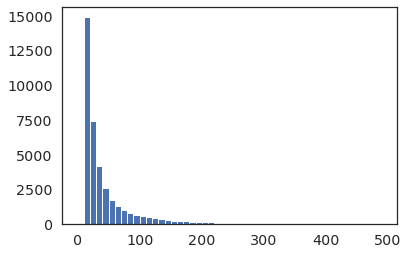

In [28]:
plt.hist(nx.get_edge_attributes(subG, 'weight').values(),bins=np.arange(0,500,10))
plt.show()

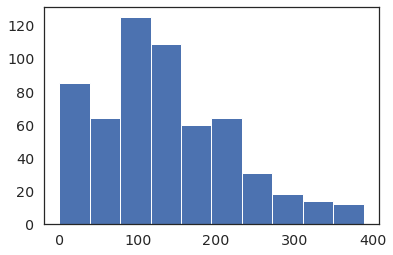

In [29]:
plt.hist(dict(subG.degree).values())
plt.show()

In [30]:
node_sizes = [0.5 * (float(i)**2) for i in nx.get_node_attributes(subG, 'size').values()]

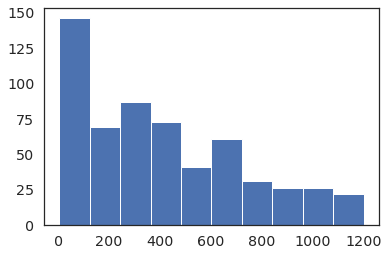

In [31]:
plt.hist(node_sizes)
plt.show()

---

## Write out results

In [34]:
edge_table = nx.to_pandas_edgelist(subG)

# Nodes
size_table = pd.DataFrame(nx.get_node_attributes(subG, "size").items(),columns=["key","size"])
fn_table = pd.DataFrame(cluster_top_terms.items(),columns=["key","go_fn"])
node_table = pd.merge(size_table, fn_table)

In [35]:
n_singletons = len(subG.nodes) - len(set(edge_table['source'].values).union(edge_table['target'].values))
print(f"There are {n_singletons} singleton clusters that don't have more than {n_connecting_edges} edges to any other cluster")

There are 6 singleton clusters that don't have more than 10 edges to any other cluster


In [36]:
edge_table

,source,target,weight
0,363960421304215792,359883270501047316,35
1,363960421304215792,2025330389306121838,205
2,363960421304215792,1623409946591431890,33
3,363960421304215792,91424709824305617,26
4,363960421304215792,1662471174741809263,171
...,...,...,...
38929,364304604371042621,67162367142536626,16
38930,1067886677771318013,831147252714132541,19
38931,1154428504703051511,576822774200611005,18
38932,2156965926792858259,1084133555757787651,15


In [37]:
node_table

,key,size,go_fn
0,363960421304215792,49,inflammatory response
1,420125125993818156,49,DNA binding
2,817247548740825171,49,GTPase activity
3,1356119026293421342,49,inflammatory response
4,647059392050788147,49,GTPase activity
...,...,...,...
577,1257609815485020910,4,
578,351383025400686933,3,
579,969183092647515912,3,
580,1498143238953243663,3,


In [38]:
edge_table.to_csv(f"{OUTPUT_DIR}/{net_name}_recipe_cluster_graph.csv",index=False)
node_table.to_csv(f"{OUTPUT_DIR}/{net_name}_recipe_cluster_graph_nodes.csv",index=False)